# Klassifikation mit einem Neuronalen Netz

## Trainingsdaten

In [11]:
# %pip install torch
# %pip install torchvision
# %pip install matplotlib

In [78]:
# Import necessary libraries/modules
from torchvision import datasets, transforms  # Import datasets and transforms from the torchvision library
from torch.utils.data import TensorDataset, DataLoader  # Import TensorDataset and DataLoader from torch.utils.data
import torch  # Import the main PyTorch library
import torch.nn as nn  # Import the neural network module from PyTorch
import torch.nn.functional as F  # Import functional components of neural networks from PyTorch
import torch.optim as optim  # Import optimization algorithms from PyTorch
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting
import numpy as np  # Import the NumPy library for numerical operations

# Define a function 'load' that loads data from a given file
def load(data):
    return np.load(data)['arr_0']  # Load data from the specified file using NumPy and return it

# Load the training and testing data and labels
train_data = load('Data\K49-data\k49-train-imgs.npz')  # Load training image data from a file
test_data = load('Data\K49-data\k49-test-imgs.npz')    # Load testing image data from a file

train_labels = load('Data\K49-data\k49-train-labels.npz')  # Load training labels from a file
test_labels = load('Data\K49-data\k49-test-labels.npz')    # Load testing labels from a file
# Convert the data to the appropriate data type (float32)
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

# Combine the training data and labels into a PyTorch TensorDataset
train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))

In [79]:
# Import the csv module for working with CSV files
import csv

# Define a list of encodings to try
encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

# Define a function to load the mapping from the CSV file with various encodings
def load_class_mapping(csv_file):
    class_mapping = None  # Initialize class_mapping as None

    for encoding in encodings_to_try:
        try:
            class_mapping = {}  # Initialize an empty dictionary to store the mapping

            # Open the CSV file specified by csv_file for reading with the current encoding
            with open(csv_file, newline='', encoding=encoding) as csvfile:
                # Create a CSV reader object that treats the first row as headers and maps columns to keys
                csvreader = csv.DictReader(csvfile)

                # Iterate through each row (record) in the CSV file
                for row in csvreader:
                    # Extract the 'index' value from the current row and convert it to an integer
                    index = int(row['index'])

                    # Extract the 'char' value from the current row
                    char = row['char']

                    # Add an entry to the class_mapping dictionary, mapping index to char
                    class_mapping[index] = char

            # If successful, break out of the loop
            break
        except UnicodeDecodeError:
            # If there's a decoding error, try the next encoding in the list
            pass

    # Check if class_mapping is still None (indicating no successful decoding)
    if class_mapping is None:
        raise ValueError("Unable to decode the CSV file with any of the specified encodings.")

    # Return the populated class_mapping dictionary containing the mapping from index to char
    return class_mapping

# Specify the path to your CSV file (e.g., "k49_classmap.csv")
csv_file_path = 'k49_classmap.csv'

# Load the class mapping from the specified CSV file by calling the load_class_mapping function
class_mapping = load_class_mapping(csv_file_path)




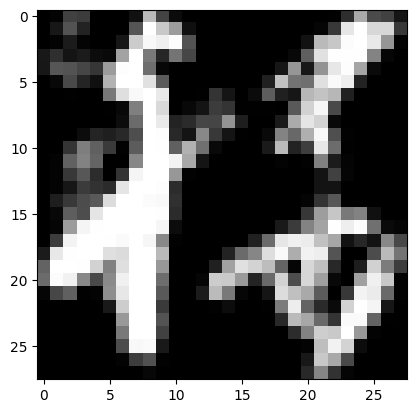

Class index 23 corresponds to character: ね


In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Define the class index you want to look up
index = 1
class_index = test_labels[index]

# Display the image using Matplotlib
plt.imshow(test_data[index], cmap='gray')
plt.show()

# Check if the class index exists in the class_mapping dictionary
if class_index in class_mapping:
    # If it exists, retrieve the corresponding character label
    character = class_mapping[class_index]

    # Print the result
    print(f"Class index {class_index} corresponds to character: {character}")
else:
    # If it doesn't exist, print a message indicating that it was not found
    print(f"Class index {class_index} not found in the mapping.")


## Definition des Neuronalen Netzes

In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Set parameters for the feedforward neural network
input_size = 784  # Update the input size to 784 (28*28)
hidden_size = 2048*2  # Number of neurons in the hidden layer
num_classes = 49    # Number of output classes (categories)
num_epochs = 20    # Number of training epochs
batch_size = 2048   # Batch size for data processing
learning_rate = 0.0005  # Learning rate for the optimizer

# Create data loaders for training and testing data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the architecture of the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        # Define the input layer that accepts 784-dimensional input
        self.input_layer = nn.Linear(input_size, input_size).to(dtype=torch.float32)
        self.l1 = nn.Linear(input_size, hidden_size).to(dtype=torch.float32)  # Fully connected layer
        self.relu = nn.ReLU()  # Rectified Linear Unit (ReLU) activation function
        # Define the output layer
        self.l2 = nn.Linear(hidden_size, num_classes).to(dtype=torch.float32)  # Fully connected layer

    def forward(self, x):  # Forward pass through the network
        x = self.input_layer(x)  # Pass input through the input layer
        out = self.l1(x)  # Pass input through the first hidden layer
        out = self.relu(out)  # Apply ReLU activation
        out = self.l2(out)  # Pass through the output layer to get predictions
        return out

# Create an instance of the neural network model
model = NeuralNet(input_size, hidden_size, num_classes)


## Training des Neuronalen Netz

In [17]:
# Define the loss function (CrossEntropyLoss) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()  # Loss function for classification problems
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with specified learning rate

# Train the model
total_step = len(train_loader)  # Total number of batches in the training data
for epoch in range(num_epochs):  # Loop through each training epoch
    for i, (train_data, train_labels) in enumerate(train_loader):  # Loop through each batch of data
        # Reshape the input images to have the shape (batch_size, input_size)
        train_data = train_data.reshape(-1, 28*28)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(train_data)

        # Calculate the loss using the defined criterion (CrossEntropyLoss)
        loss = criterion(outputs, train_labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from previous steps
        loss.backward()  # Perform backpropagation to compute gradients
        optimizer.step()  # Update model parameters using the computed gradients

        # Print training statistics
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


KeyboardInterrupt: 

In [ ]:
# After training the model, save it to a file
torch.save(model.state_dict(), 'mymodel.pth')


## Test des Neuronalen Netzes

In [ ]:
# Initialize lists to store predictions and ground truth labels
p_test = []  # Model predictions of class index
y_test = []  # Ground truth class indices

# Loop through the test data in batches
for images, labels in test_loader:
    images = images.reshape(-1, 28*28)  # Reshape input images
    images = images.to(dtype=torch.float32)  # Cast images to the correct data type (torch.float32)
    outputs = model(images)  # Forward pass to get model predictions
    _, predicted = torch.max(outputs.data, 1)  # Get the predicted class for each sample

    # Append model predictions and ground truth labels to lists
    p_test.extend(predicted.tolist())
    y_test.extend(labels.tolist())

# Calculate balanced accuracy using the provided implementation
accs = []

# Loop through each class (in this case, there are 49 classes)
for cls in range(49):
    # Create a mask to select samples of the current class in the ground truth
    mask = (torch.tensor(y_test) == cls)
    
    # Calculate the accuracy for samples of the current class
    cls_acc = (torch.tensor(p_test) == cls)[mask].float().mean()  # Accuracy for rows of class cls
    
    # Append the class accuracy to the list of accuracies
    accs.append(cls_acc)

# Calculate the final balanced accuracy by taking the mean of class accuracies
balanced_accuracy = torch.tensor(accs).mean().item()

# Print the balanced accuracy as a percentage
print('Balanced Accuracy of the model on test images: {:.2f} %'.format(100 * balanced_accuracy))


Balanced Accuracy of the model on test images: 80.96 %


In [97]:
import tkinter as tk  # Import the tkinter library for creating the GUI
import win32gui  # Import win32gui for interacting with the Windows GUI
from PIL import ImageGrab, Image  # Import the PIL library for image processing
import csv  # Import the CSV library for reading CSV files

# Define a function to load the class mapping from a CSV file with various encodings
def load_class_mapping(csv_file):
    # Define a list of encodings to try when reading the CSV file
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    # Iterate through the list of encodings and attempt to read the CSV file
    for encoding in encodings_to_try:
        try:
            # Initialize an empty dictionary to store the class mapping
            class_mapping = {}   
            # Open the CSV file with the specified encoding

            with open(csv_file, newline='', encoding=encoding) as csvfile:
                csvreader = csv.DictReader(csvfile)          
                # Iterate through each row in the CSV file

                for row in csvreader:
                    # Extract the 'index' and 'char' values from the row
                    index = int(row['index'])
                    char = row['char']                  
                    # Add the mapping of 'index' to 'char' in the class_mapping dictionary
                    class_mapping[index] = char
            # Return the class mapping if successful

            return class_mapping
        # Handle Unicode decoding errors

        except UnicodeDecodeError:
            continue   
    # Raise an exception if unable to decode the CSV file with any of the specified encodings
    raise ValueError("Unable to decode the CSV file with any of the specified encodings.")

# Specify the path to your CSV file (e.g., "k49_classmap.csv")
csv_file_path = 'k49_classmap.csv'

# Load the class mapping from the CSV file using the function
class_mapping = load_class_mapping(csv_file_path)

# Define your neural network model and load pre-trained weights
model = NeuralNet(input_size, hidden_size, num_classes)  # Create an instance of the neural network
model.load_state_dict(torch.load('mymodel.pth'))  # Load pre-trained weights
model.eval()  # Set the model to evaluation mode (no training)

# Create a tkinter GUI application
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)  # Initialize the tkinter application
        self.x = self.y = 0  # Initialize mouse coordinates
        self.drawing_area = tk.Canvas(self, width=28*20, height=28*20, bg="white", cursor="cross")  # Create a canvas for drawing
        self.result_label = tk.Label(self, font=("Helvetica", 24))  # Create a label for displaying recognized character
        self.classify_btn = tk.Button(self, text="Recognize", command=self.classify_handwriting)  # Create a button for recognition
        self.button_clear = tk.Button(self, text="Clear", command=self.clear_all)  # Create a button to clear the canvas
        
        # Variables to track drawing
        self.drawing = False  # Initialize drawing state
        self.last_x = 0  # Initialize last mouse X coordinate
        self.last_y = 0  # Initialize last mouse Y coordinate

        # Bind mouse events to functions
        self.drawing_area.bind("<Button-1>", self.start_drawing)  # Bind left mouse button press to start_drawing function
        self.drawing_area.bind("<B1-Motion>", self.draw_lines)  # Bind mouse motion to draw_lines function
        self.drawing_area.bind("<ButtonRelease-1>", self.stop_drawing)  # Bind left mouse button release to stop_drawing function

        # Grid structure for placing widgets
        self.drawing_area.grid(row=0, column=0, pady=2, sticky=tk.W)  # Place the canvas in the grid
        self.result_label.grid(row=0, column=1, pady=2, padx=2)  # Place the label in the grid
        self.classify_btn.grid(row=1, column=0, pady=2)  # Place the classify button in the grid
        self.button_clear.grid(row=2, column=0, pady=2)  # Place the clear button in the grid

    def start_drawing(self, event):
        self.drawing = True  # Set drawing state to True
        self.last_x = event.x  # Record the current mouse X coordinate
        self.last_y = event.y  # Record the current mouse Y coordinate
    def draw_lines(self, event):
        if self.drawing:
            x, y = event.x, event.y  # Get the current mouse coordinates
            # Calculate the number of intermediate points to add
            num_points = max(abs(x - self.last_x), abs(y - self.last_y))
            
            if num_points > 0:
                # Calculate the step size for the interpolation
                x_step = (x - self.last_x) / num_points
                y_step = (y - self.last_y) / num_points
                
                for _ in range(int(num_points)):  # Convert num_points to an integer
                    # Create a line from the last recorded coordinates to an intermediate point
                    self.drawing_area.create_line(
                        (self.last_x, self.last_y, self.last_x + x_step, self.last_y + y_step),
                        fill="black",
                        width=30
                    )
                    
                    # Update the last coordinates for the next iteration
                    self.last_x += x_step
                    self.last_y += y_step

    def stop_drawing(self, event):
        self.drawing = False  # Set drawing state to False

    def clear_all(self):
        self.drawing_area.delete("all")  # Clear the canvas
        self.result_label.configure(text="")  # Clear the result label

    def classify_handwriting(self):
        #if self.drawing_area.find_all():
            #drawn_area = self.drawing_area.bbox("all") # Get the bounding box of all items on the canvas 
            #x1, y1, x2, y2 = drawn_area # Extract the coordinates of the bounding box
            # This helps to only take the Region of Intrest
            # So if the user only draws in the top-left corner. It does not affect the output        
            HWND = self.drawing_area.winfo_id()  # Get the window ID of the drawing area
            rect = win32gui.GetWindowRect(HWND)  # Get the coordinates of the drawing area
            withoutLine = 0
            rect = (rect[0] + withoutLine, rect[1] + withoutLine, rect[2] - withoutLine, rect[3] - withoutLine)
            im = ImageGrab.grab(rect)  # Capture the screen area within the drawing area        
            # Preprocess the image for character recognition
            #im = im.crop((x1, y1, x2, y2)) # Crop the image to a smaller region defined by a new bounding box
            im = im.resize((28, 28))  # Resize image to 28x28 pixels
            im = im.convert('L')  # Convert RGB to grayscale
            im = np.array(im)  # Convert to NumPy array
            im = 255 - im
            im = im.astype(np.float32)
            im = im.reshape(-1, 28 * 28)  # Reshape to (1, 784)
            print(im)
        # Convert to PyTorch tensor
            img_tensor = torch.tensor(im, dtype=torch.float32)
        
        # Predicting the class
            with torch.no_grad():
                outputs = model(img_tensor)  # Forward pass to get model predictions

    # Get the top 3 predicted classes and their probabilities
                _, top_classes = torch.topk(outputs, 3, dim=1)
                top_probabilities = torch.softmax(outputs, dim=1)[0, top_classes].numpy()

            # Initialize an empty list to store the top recognized characters and their confidence percentages
            top_recognized_chars = []

            # Loop through the top 3 predicted classes
            for i in range(3):
                # Get the class index from the top_classes tensor
                class_index = top_classes[0, i].item()
                # Check if the class index exists in the class_mapping dictionary
                if class_index in class_mapping:
                # Retrieve the recognized character for the class index
                    recognized_char = class_mapping[class_index]      
                    # Get the confidence (probability) for the current prediction
                    confidence = top_probabilities[0, i]        
                    # Calculate the accuracy percentage by multiplying confidence by 100 and rounding to 2 decimal places
                    accuracy_percentage = round(confidence * 100, 2)
                    # Append a tuple containing the recognized character and its accuracy percentage to the list
                    top_recognized_chars.append((recognized_char, accuracy_percentage))
                    # Now, you can update your result_label with the top 3 recognized characters and their percentages

                    # Check if there are top recognized characters in the list
                if top_recognized_chars:
                    # If there are recognized characters, create a formatted result text
                    result_text = "\n".join([f"{char} ({percentage}%)" for char, percentage in top_recognized_chars])
                    # Update the text of the result_label widget with the formatted result text
                    self.result_label.configure(text=result_text)
                else:
                    # If no recognized characters are found, display a message
                    self.result_label.configure(text="No recognized characters found in the mapping")

# Create an instance of the App class
app = App()
# Run the GUI application
app.mainloop()


[[239. 114.  43.  39.  24.  11.  12.  12.  12.  12.  12.  12.  12.  12.
   12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.]
 [233. 109.  18.  22.  19.  12.  13.  13.  13.  13.  13.  13.  13.  13.
   13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.]
 [242. 112.   0.   3.   3.   4.   4.   4.   4.   4.   4.   4.   4.   4.
    4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.]
 [243. 113.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\AppData\Local\Temp\ipykernel_9744\3026150142.py", line 134, in classify_handwriting
    outputs = model(img_tensor)  # Forward pass to get model predictions
              ^^^^^^^^^^^^^^^^^
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\AppData\Local\Temp\ipykernel_9744\3925496919.py", line 38, in forward
    x = self.input_layer(x)  # Pass input through the input layer
        ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_i

[[239. 114.  43.  39.  24.  11.  12.  12.  12.  12.  12.  12.  12.  12.
   12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.]
 [233. 109.  18.  22.  19.  12.  13.  13.  13.  13.  13.  13.  13.  13.
   13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.]
 [242. 112.   0.   3.   3.   4.   4.   4.   4.   4.   4.   4.   4.   4.
    4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.]
 [243. 113.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [243. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\AppData\Local\Temp\ipykernel_9744\3026150142.py", line 134, in classify_handwriting
    outputs = model(img_tensor)  # Forward pass to get model predictions
              ^^^^^^^^^^^^^^^^^
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sebastian\AppData\Local\Temp\ipykernel_9744\3925496919.py", line 38, in forward
    x = self.input_layer(x)  # Pass input through the input layer
        ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_i